In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

In [69]:
class Solver:
    def __init__(self, a, b, c, d, f, u_start, dt_u_start, left_border_condition, right_border_condition, left_border, right_border, n, sigma, end_time) -> None:
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.f = f
        self.u_start = u_start
        self.dt_u_start = dt_u_start
        self.left_border = left_border
        self.right_border = right_border
        self.l = right_border-left_border

        self.n = n
        self.sigma = sigma
        self.end_time = end_time
        self.h = self.l/(n-1)
        self.time_steps = int((end_time*a**2*n)/(sigma*self.l))-1
        self.tau = (sigma*self.l)/(a**2*n)

        self.left_border_condition = left_border_condition
        self.right_border_condition = right_border_condition

        self.left_a = 1
        self.left_b = 1
        self.right_a = 1
        self.right_b = 1

    def solve(self, scheme, boundary_conditions_interpolation):
        a = self.a
        b = self.b
        c = self.c
        d = self.d
        f = self.f
        u_start = self.u_start
        dt_u_start = self.dt_u_start
        left_border = self.left_border
        right_border = self.right_border
        l = self.l

        n = self.n
        sigma = self.sigma
        end_time = self.end_time
        h = self.h
        time_steps = self.time_steps
        tau = self.tau

        left_border_condition = self.left_border_condition
        right_border_condition = self.right_border_condition

        left_a = self.left_a
        left_b = self.left_b
        right_a = self.right_a
        right_b = self.right_b

        u = np.zeros((time_steps, n))
        linspace = np.linspace(left_border, right_border+h, n)
        u[0] = u_start(linspace)
        u[1] = u[0]+tau*dt_u_start(linspace)

        if scheme == 'explicit':

            for k in range(1, time_steps-1):
                for i in range(1, n-1):
                    u[k+1, i] = ((a**2)*(u[k, i-1]-2*u[k, i]+u[k, i+1])/(h**2)+ \
                                b*(u[k, i+1]-u[k, i-1])/(2*h)+ \
                                c*u[k, i]+ \
                                f(left_border+i*h, k*tau)-d*(u[k-1, i]/(2*tau))-(u[k-1, i]-2*u[k, i])/(tau**2)) \
                                / \
                                (1/(tau**2)-d/(2*tau))

                if boundary_conditions_interpolation == '2_points_1st_order':
                    u[k+1, 0] = (left_border_condition((k+1)*tau)-(left_a/h)*u[k+1, 1])/(-(left_a/h)+left_b)
                    u[k+1, -1] = (right_border_condition((k+1)*tau)+(right_a/h)*u[k+1, -2])/ \
                                       ((right_a/h)+right_b)
  
                if boundary_conditions_interpolation == '3_points_2nd_order':
                    u[k+1, 0] = (left_border_condition((k+1)*tau)-((4*left_a)/(2*h)*u[k+1, 1])+(left_a/(2*h))*u[k+1, 2])/ \
                                (((-3)*left_a)/(2*h)+left_b)
                    u[k+1, -1] = (right_border_condition((k+1)*tau)+((4*right_a)/(2*h)*u[k+1, -2])-(right_a/(2*h))*u[k+1, -3])/ \
                                       ((3*right_a)/(2*h)+right_b)

                if boundary_conditions_interpolation == '2_points_2nd_order':
                    denominator = h-(b*h**2)/(2*a**2)
                    u[k+1, 0] = (left_border_condition((k+1)*tau)-((left_a*h**2)/(2*a**2))*f(left_border, (k+1)*tau)-u[k+1, 1]*left_a/denominator-u[k, 0]*((-left_a*d*h**2)/(2*a**2*tau))/denominator-u[k-1, 0]*((-left_a*h**2)/(2*a**2*tau**2))/denominator)/(-left_a/denominator-((left_a*h**2)/(2*a**2*tau**2))/denominator+((left_a*c*h**2)/(2*a))/denominator+((left_a*d*h**2)/(2*a**2*tau))/denominator+left_b)
                    denominator = -h-(b*h**2)/(2*a**2)
                    u[k+1, -1] = (right_border_condition((k+1)*tau)-((right_a*h**2)/(2*a**2))*f(right_border, (k+1)*tau)-u[k+1, -2]*right_a/denominator-u[k, 0]*((-right_a*d*h**2)/(2*a**2*tau))/denominator-u[k-1, 0]*((-right_a*h**2)/(2*a**2*tau**2))/denominator)/(-right_a/denominator-((right_a*h**2)/(2*a**2*tau**2))/denominator+((right_a*c*h**2)/(2*a))/denominator+((right_a*d*h**2)/(2*a**2*tau))/denominator+right_b)

        if scheme == 'implicit':
            alpha = (a**2)/(h**2)-(b)/(2*h)
            beta = -1/(tau**2)-(2*a**2)/(h**2)+c+d/(2*tau)
            gamma = (a**2)/(h**2)+(b)/(2*h)
            denominator = h-(b*h**2)/(2*a**2)

            A = np.zeros((n, n))
            if boundary_conditions_interpolation == '2_points_1st_order':
                A[0, 0] = (-(left_a/h)+left_b)
                A[0, 1] = (left_a/h)
                A[-1, -1] = ((right_a/h)+right_b)
                A[-1, -2] = -(right_a/h)
            if boundary_conditions_interpolation == '3_points_2nd_order':
                A[0, 0] = (((-3)*left_a)/(2*h)+left_b)
                A[0, 1] = (4*left_a)/(2*h)
                A[0, 2] = (-left_a)/(2*h)
                A[-1, -1] = ((3*right_a)/(2*h)+right_b)
                A[-1, -2] = ((-4)*right_a)/(2*h)
                A[-1, -3] = (right_a)/(2*h)

            if boundary_conditions_interpolation == '2_points_2nd_order':
                A[0, 0] = -left_a/denominator-((left_a*h**2)/(2*a**2*tau**2))/denominator+((left_a*c*h**2)/(2*a))/denominator+((left_a*d*h**2)/(2*a**2*tau))/denominator+left_b
                A[0, 1] = left_a/denominator
                A[-1, -1] = -right_a/(-denominator)-((right_a*h**2)/(2*a**2*tau**2))/(-denominator)+((right_a*c*h**2)/(2*a))/(-denominator)+((right_a*d*h**2)/(2*a**2*tau))/(-denominator)+right_b
                A[-1, -2] = right_a/(-denominator)
            for i in range(1, n-1):
                A[i, i-1] = alpha
                A[i, i] = beta
                A[i, i+1] = gamma
            
            for k in range(2, time_steps):
                d_vector = -np.array([f(left_border+i*h, k*tau) for i in range(n)])
                d_vector += (-2*u[k-1]+u[k-2])/(tau**2)+(d*u[k-2])/(2*tau)
                d_vector[0] = left_border_condition(k*tau)
                d_vector[-1] = right_border_condition(k*tau)
                if boundary_conditions_interpolation == '2_points_2nd_order':
                    d_vector[0] -= ((left_a*h**2)/(2*a**2))*f(left_border, k*tau)+u[k-1, 0]*((-left_a*d*h**2)/(2*a**2*tau))/denominator-u[k-2, 0]*((-left_a*h**2)/(2*a**2*tau**2))/denominator
                    d_vector[-1] -= ((right_a*h**2)/(2*a**2))*f(right_border, k*tau)+u[k-1, -1]*((-right_a*d*h**2)/(2*a**2*tau))/(-denominator)-u[k-2, -1]*((-right_a*h**2)/(2*a**2*tau**2))/(-denominator)
                u[k] = np.linalg.solve(A, d_vector)

        return u

In [80]:
from difflib import restore

def u_start(x):
    return np.sin(x)

def dt_u_start(x):
    return -np.sin(x)

def Left_border_condition(t):
    return np.exp(-t)
def Right_border_condition(t):
    return -np.exp(-t)

def f(x, t):
    return -np.cos(x)*np.exp(-t)

a = 1
b = 1
c = -1
d = -3
left_border = 0
right_border = math.pi

n = 20
sigma = 0.1

end_time = 4

solver = Solver(a, b, c, d, f, u_start, dt_u_start, Left_border_condition, Right_border_condition, left_border, right_border, n, sigma, end_time)
u = solver.solve('explicit', '2_points_1st_order')
# u = solver.solve('explicit', '3_points_2nd_order')
# u = solver.solve('explicit', '2_points_2nd_order')
# u = solver.solve('implicit', '2_points_2nd_order')
# u = solver.solve('implicit', '2_points_1st_order')
# u = solver.solve('combined', '2_points_2nd_order')
# u = solver.solve('combined', '2_points_1st_order')

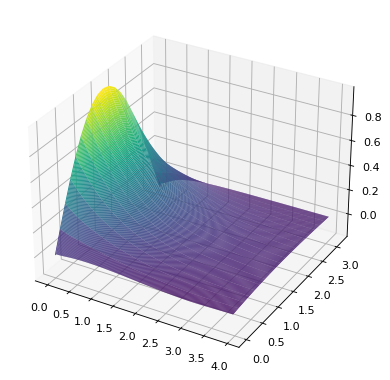

In [81]:
X = np.array([[solver.tau*k for i in range(0, n)] for k in range(solver.time_steps)])
Y = np.array([[left_border+solver.h*i for i in range(0, n)] for k in range(solver.time_steps)])
Z = np.array([[u[k, i] for i in range(0, n)] for k in range(solver.time_steps)])


plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')